In [1]:
import os
import sys
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import torchattacks
from torchattacks import PGD

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
mean, std = [0.4914, 0.4822, 0.4465 ], [ 0.2023, 0.1994, 0.2010 ], 

train_transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean,std),
    ])

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])


cifar10_train = dsets.CIFAR10(root='./data', train=True,
                                       download=True, transform=train_transform)
cifar10_test  = dsets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=50,
                                         shuffle=True, num_workers=1)

test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=50,
                                        shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

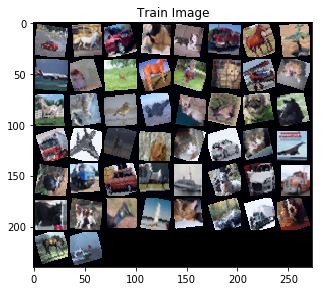

In [7]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

# Generate Opt Means

In [8]:
def generate_opt_means(C, p, L): 
    """
    input
        C = constant value
        p = dimention of feature vector
        L = class number
    """
    opt_means = np.zeros((L, p))
    opt_means[0][0] = 1
    for i in range(1,L):
        for j in range(i): 
            opt_means[i][j] = - (1/(L-1) + np.dot(opt_means[i],opt_means[j])) / opt_means[j][j]
        opt_means[i][i] = np.sqrt(1 - np.linalg.norm(opt_means[i])**2)
    for k in range(L):
        opt_means[k] = C * opt_means[k]
        
    return opt_means

# MM_LDA layer
- Max Mahalanobis - Linear Discriminant Analysis

In [9]:
class MM_LDA(nn.Module):
    def __init__(self, C, n_dense, class_num, device, Normalize=False):
        super().__init__()
        """
        C : hyperparam for generating MMD
        n_dense : dimention of the feature vector
        class_num : dimention of classes
        """
        self.C = C
        self.class_num = class_num
        opt_means = generate_opt_means(C, n_dense, class_num)
        self.mean_expand = torch.tensor(opt_means).unsqueeze(0).double().to(device) # (1, num_class, num_dense)
        self.Normalize = Normalize
        
    def forward(self, x):
#         print('x', x, x.shape)
        b, p = x.shape # batch_size, num_dense
        L = self.class_num
        if self.Normalize: # 正規化する
            x = (x / (torch.norm(x, p=2, dim=1, keepdim=True) + 1e-10)) * self.C
#             print(torch.norm(x, p=2, dim=1, keepdim=True))
            
        x_expand =  x.repeat(1,L).view(b, L, p).double() # (batch_size, num_class, num_dense)

        logits = - torch.sum((x_expand - self.mean_expand)**2, dim=2) # (batch_size, num_class)
#         print('x-mean',x_expand - self.mean_expand)
#         print('logits', logits, logits.shape)
 
        return logits

In [16]:
class dot_loss(nn.Module):
    def __init__(self):
        super(dot_loss, self).__init__()

    def forward(self, y_pred, y_true):
        y_true = F.one_hot(y_true, num_classes=y_pred.size(1)).double()
        loss = - torch.sum(y_pred * y_true, dim=1) #batch_size X 1
#         print('y_pred, y_true, loss',y_pred, y_true, loss.sum())
        return loss.mean()

# Train

In [10]:
# Training
def train(model, train_loader, criterion, optimizer, epoch, args, to_print=True):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * targets.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    if to_print:
        print('- Train Loss: %.4f, Acc: %.3f%% (%d/%d)'
              %( train_loss/total, 100.*correct/total, correct, total ))

    return train_loss/total


def test(model, test_loader, criterion, epoch, args, to_print=False):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
 
            test_loss += loss.item() * targets.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
        if to_print:
            print('- Test Loss: %.4f, Acc: %.3f%% (%d/%d)'
              %(test_loss/total, 100.*correct/total, correct, total ))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'state_dict': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir(args.save_file_name):
            os.mkdir(args.save_file_name)
        torch.save(state, args.save_file_name + '/ckpt.pth')
        best_acc = acc
    
    return test_loss/total

# Train - MM_LDA
- Max-mahalanobis linear discriminant analysis networks (ICML 2018)

In [11]:
class opts(object):
    def __init__(self):
        self.arch = 'resnet34'
        self.save_file_name = './exps/checkpoint_' + self.arch  +'_MMLDA'

args = opts()

In [21]:
model = models.resnet34(pretrained=False)
model.fc = nn.Linear(512,256) # use_dense
# MM_LDA 
C, n_dense, class_num = 100, 256, 10
mm_lda_layer = MM_LDA(C, n_dense, class_num, device, Normalize=True) 

model = nn.Sequential(model, mm_lda_layer) 
model = model.to(device)

file_name = args.save_file_name + '/ckpt.pth'

# try:
#     checkpoint = torch.load(file_name)
#     model.load_state_dict(checkpoint['state_dict'])
#     print('Loaded ... ', file_name)
#     best_acc = checkpoint['acc']
# except:
best_acc = 0
print('No exps found')
best_acc

No exps found


0

In [22]:
best_acc = 60

In [27]:
criterion = nn.CrossEntropyLoss()

def iter_epochs(model, epoch_list, lr_list):
    for epochs, lr in zip(epoch_list, lr_list):
        for epoch in range(epochs):
            to_print = True if epoch%1==0 else False
            optimizer = optim.SGD(model.parameters(), lr=lr,momentum=0.9)
            train_loss = train(model, train_loader, criterion, optimizer, epoch, args, to_print=to_print)
            test_loss = test(model, test_loader, criterion, epoch, args, to_print=to_print)
            Train_losses.append(train_loss)
            Test_losses.append(test_loss)

Train_losses = []
Test_losses = []
# iter_epochs(model, [100,50,50],[0.01,0.001,0.0001])
iter_epochs(model, [20],[0.1])


Epoch: 0
- Train Loss: 174.9568, Acc: 15.314% (7657/50000)
- Test Loss: 74.1831, Acc: 15.840% (1584/10000)

Epoch: 1
- Train Loss: 48.2682, Acc: 19.288% (9644/50000)
- Test Loss: 19.3258, Acc: 28.190% (2819/10000)

Epoch: 2
- Train Loss: 32.5879, Acc: 22.830% (11415/50000)
- Test Loss: 23.6093, Acc: 23.380% (2338/10000)

Epoch: 3
- Train Loss: 23.5246, Acc: 25.130% (12565/50000)
- Test Loss: 11.5846, Acc: 35.590% (3559/10000)

Epoch: 4
- Train Loss: 21.3372, Acc: 25.996% (12998/50000)
- Test Loss: 21.9824, Acc: 23.650% (2365/10000)

Epoch: 5
- Train Loss: 18.3936, Acc: 27.558% (13779/50000)
- Test Loss: 19.6574, Acc: 27.730% (2773/10000)

Epoch: 6
- Train Loss: 16.7471, Acc: 28.820% (14410/50000)
- Test Loss: 8.7887, Acc: 33.840% (3384/10000)

Epoch: 7
- Train Loss: 15.5509, Acc: 29.110% (14555/50000)
- Test Loss: 12.6968, Acc: 33.420% (3342/10000)

Epoch: 8
- Train Loss: 14.3882, Acc: 29.822% (14911/50000)
- Test Loss: 18.2127, Acc: 30.180% (3018/10000)

Epoch: 9
- Train Loss: 13.936

# Train - MMC Loss

In [29]:
class opts(object):
    def __init__(self):
        self.arch = 'resnet34'
        self.save_file_name = 'exps/checkpoint_' + self.arch  +'_MMC'

args = opts()

In [30]:
model = models.resnet34(pretrained=False)
model.fc = nn.Linear(512,256) # use_dense
# MM_LDA 
# if MMC_10 => C=10. 
C, n_dense, class_num = 10, 256, 10
mm_lda_layer = MM_LDA(C, n_dense, class_num, device, Normalize=True) 

model = nn.Sequential(model, mm_lda_layer)
model = model.to(device)

file_name = args.save_file_name + '/ckpt.pth'

try:
    checkpoint = torch.load(file_name)
    model.load_state_dict(checkpoint['state_dict'])
    print('Loaded ... ', file_name)
    best_acc = checkpoint['acc']
except:
    best_acc = 0
    print('No exps found')
best_acc

Loaded ...  exps/checkpoint_resnet34_MMC/ckpt.pth


80.68

In [ ]:
criterion = dot_loss()

def iter_epochs(model, epoch_list, lr_list):
    for epochs, lr in zip(epoch_list, lr_list):
        for epoch in range(epochs):
            to_print = True if epoch%1==0 else False
            optimizer = optim.SGD(model.parameters(), lr=lr,momentum=0.9)
            train_loss = train(model, train_loader, criterion, optimizer, epoch, args, to_print=to_print)
            test_loss = test(model, test_loader, criterion, epoch, args, to_print=to_print)
            Train_losses.append(train_loss)
            Test_losses.append(test_loss)

Train_losses = []
Test_losses = []
# iter_epochs(model, [100,50,50],[0.01,0.001,0.0001])
iter_epochs(model, [50],[0.0001])


Epoch: 0
- Train Loss: 29.2057, Acc: 85.136% (42568/50000)
- Test Loss: 38.8878, Acc: 80.360% (8036/10000)

Epoch: 1
- Train Loss: 28.8992, Acc: 85.226% (42613/50000)
- Test Loss: 38.6684, Acc: 80.540% (8054/10000)

Epoch: 2
- Train Loss: 29.1812, Acc: 85.238% (42619/50000)
- Test Loss: 38.8486, Acc: 80.350% (8035/10000)

Epoch: 3
- Train Loss: 28.6814, Acc: 85.444% (42722/50000)
- Test Loss: 38.7556, Acc: 80.310% (8031/10000)

Epoch: 4
- Train Loss: 28.6570, Acc: 85.472% (42736/50000)
- Test Loss: 38.7708, Acc: 80.400% (8040/10000)

Epoch: 5
- Train Loss: 28.8942, Acc: 85.226% (42613/50000)
- Test Loss: 38.5888, Acc: 80.580% (8058/10000)

Epoch: 6


# Train - Cross Entropy Loss

In [985]:
class opts(object):
    def __init__(self):
        self.arch = 'resnet34'
        self.MMC = False
        self.save_file_name = 'exps/checkpoint_' + self.arch 

args = opts()

In [984]:
model = models.resnet34(pretrained=False)
model.fc = nn.Linear(512,10) #for CIFAR10
model = model.to(device)

file_name = args.save_file_name + '/ckpt.pth'

try:
    checkpoint = torch.load(file_name)
    model.load_state_dict(checkpoint['state_dict'])
    print('Loaded ... ', file_name)
    best_acc = checkpoint['acc']
except:
    best_acc = 0
    print('No exps found')
best_acc


In [ ]:
criterion = nn.CrossEntropyLoss()

def iter_epochs(model, epoch_list, lr_list):
    for epochs, lr in zip(epoch_list, lr_list):
        for epoch in range(epochs):
            to_print = True if epoch%10==0 else False
            optimizer = optim.SGD(model.parameters(), lr=lr,momentum=0.9, weight_decay=5e-4)
            train_loss = train(model, train_loader, criterion, optimizer, epoch, args, to_print=to_print)
            test_loss = test(model, test_loader, criterion, epoch, args, to_print=to_print)
            Train_losses.append(train_loss)
            Test_losses.append(test_loss)

Train_losses = []
Test_losses = []
iter_epochs(model, [100,50,50],[0.1,0.01,0.001])


Epoch: 0
- Train Loss: 2.3869, Acc: 17.028% (8514/50000)
- Test Loss: 1.9207, Acc: 23.460% (2346/10000)
Saving..

Epoch: 1
Saving..

Epoch: 2
Saving..

Epoch: 3
Saving..

Epoch: 4

Epoch: 5
Saving..

Epoch: 6
Saving..

Epoch: 7
Saving..

Epoch: 8

Epoch: 9

Epoch: 10
- Train Loss: 1.2385, Acc: 56.402% (28201/50000)
- Test Loss: 1.0263, Acc: 64.250% (6425/10000)
Saving..

Epoch: 11

Epoch: 12

Epoch: 13

Epoch: 14

Epoch: 15

Epoch: 16

Epoch: 17

Epoch: 18

Epoch: 19

Epoch: 20
- Train Loss: 1.1466, Acc: 60.242% (30121/50000)
- Test Loss: 0.9987, Acc: 64.910% (6491/10000)
Saving..

Epoch: 21

Epoch: 22
Saving..

Epoch: 23

Epoch: 24

Epoch: 25
Saving..

Epoch: 26

Epoch: 27

Epoch: 28

Epoch: 29

Epoch: 30
- Train Loss: 1.1276, Acc: 61.202% (30601/50000)
- Test Loss: 0.9796, Acc: 65.960% (6596/10000)

Epoch: 31

Epoch: 32

Epoch: 33

Epoch: 34

Epoch: 35
Saving..

Epoch: 36

Epoch: 37

Epoch: 38

Epoch: 39

Epoch: 40
- Train Loss: 1.1082, Acc: 61.960% (30980/50000)
- Test Loss: 1.1925